In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


rs = 132
dataset = pd.read_csv('./data/dataset.csv', dtype={"股票代码": "object"})
# dataset.set_index('股票简称', inplace=True)
dataset.set_index(['股票代码', "截止日期"], inplace=True)
features = ['净资产收益率(%)', '资产报酬率(%)', 'EBITDA率(%)', '营业收入增长率(%)', '成本费用利润率(%)', '总资产周转率(%)', '应收账款周转率(%)', '存货周转率(%)', '营业周期', '现金资产比率(%)', '技术人员占比(%)', '研发营收比(%)', '发明专利申请数', '数字化软硬件投入比(%)', '数字化战略导向前瞻性', '数字化战略导向持续性', '数字化战略导向广度', '数字化战略导向强度', '数字发明专利', '数字国家级奖项', '数字创新论文', '数字创新标准', '数字创新资质', '管理层数字职务设立', '两权分离率(%)', '数字人力计划投入', '数字资本计划投入', '科技创新基地建设', '员工人均营收比(%)', '提供岗位增长率(%)', '员工收入增长率(%)', '社会责任报告质量', '供应链合作伙伴', '数字化供应链覆盖度', '客户集中度(%)', '供应商集中度(%)']
label_name = 'score'
# 获取数据集和标签值
y : pd.Series = dataset[label_name]
X : pd.DataFrame = dataset[features].copy(deep=True).astype("float")
# 数据预处理：1.极差标准化；2.数据集划分。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from utils.config import table_translate
from tensorflow import keras
from utils.methods import r2


Pred = pd.DataFrame()
Pred["true"] = y_test
metrics_matrix = pd.DataFrame(columns=["Model", "MSE", "RSME",  "MAE", "R2"])
params= {'ccp_alpha': 2.836687623847209e-10, 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 33}

model = DecisionTreeRegressor(max_features="sqrt", random_state=rs, **params)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
metrics_matrix.loc[metrics_matrix.shape[0]] = ["DecisionTree", mse,np.sqrt(mse),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)]
Pred["DecisionTree"] = y_pred

params = {'max_depth': 14, 'max_features': 27, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 127}
model = RandomForestRegressor(verbose=0, random_state=rs, **params)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
metrics_matrix.loc[metrics_matrix.shape[0]] = ["RandomForest", mse,np.sqrt(mse),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)]
Pred["RandomForest"] = y_pred

params = {"objective": 'reg:squarederror', 'colsample_bytree': 0.92, 'gamma': 0, 'learning_rate': 0.3, 'max_depth':3,  'min_child_weight': 5, 'n_estimators': 39, 'subsample': 0.5, "reg_alpha": 0, "reg_lambda": 0, "scale_pos_weight": 1}
model = XGBRegressor(random_state=rs, **params, n_jobs=-1)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
metrics_matrix.loc[metrics_matrix.shape[0]] = ["XGBoost", mse,np.sqrt(mse),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)]
# metrics_matrix.loc[metrics_matrix.shape[0]] = ["XGBoost", 0.897, 83.709, 6.061]
Pred["XGBoost"] = y_pred

params = {"iterations": 300, "learning_rate": 0.36, "depth": 2, "l2_leaf_reg": 0.21, 'bagging_temperature': 0.1, "border_count": 49}
model = CatBoostRegressor(random_state=rs, verbose=0, train_dir=None, allow_writing_files=False, **params)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
metrics_matrix.loc[metrics_matrix.shape[0]] = ["CatBoost", mse,np.sqrt(mse),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)]
Pred["CatBoost"] = y_pred

params = { "objective": 'mse', 'max_depth': 2, "n_estimators": 200, 'learning_rate': 0.31, 'min_child_samples': 2,  'reg_alpha': 0, 'reg_lambda': 0, "force_col_wise": True, "subsample": 0.8, 'colsample_bytree': 0.38, "num_leaves": 4}
model = LGBMRegressor(n_jobs=-1, random_state=rs, verbosity=-1, **params)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
metrics_matrix.loc[metrics_matrix.shape[0]] = ["LGBoost", mse,np.sqrt(mse),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)]
Pred["LGBoost"] = y_pred

# Sequential 模型适用于普通层堆栈 其中，每层只有一个 input Tensor 和一个 Output Tensor。
model = keras.models.Sequential()
# model.add(keras.Input(shape=(X_train_s.shape[1], )))
model.add(keras.layers.Dense(units=50, activation='relu', name="layer1", input_shape=(X_train_s.shape[1], ), kernel_regularizer=keras.regularizers.l2(0.002)))
# model.add(keras.layers.Dropout(0.02))

# 增加输出层
model.add(keras.layers.Dense(units=1, name="output"))
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse', r2, 'mae'])
# 查看模型结构
# utils.plot_model(model, "./assert/feature_importance/bp_model_structure.png", show_shapes=True)
# model.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=70, restore_best_weights=True)
hist = model.fit(X_train_s, y_train, validation_split=0.2, epochs=100, batch_size=100, shuffle=True, verbose=0,callbacks=[early_stopping])

s = model.evaluate(X_test_s, y_test, verbose=0)
pd.DataFrame(hist.history).to_csv('./assert/temp/bp_model_loss.csv')
y_pred = model.predict(X_test_s)
Pred["ANN"] = y_pred
mse = mean_squared_error(y_test, y_pred)
metrics_matrix.loc[metrics_matrix.shape[0]] = ["ANN", mse,np.sqrt(mse),mean_absolute_error(y_test, y_pred),r2_score(y_test, y_pred)]
metrics_matrix = metrics_matrix.round(3)
table_translate(metrics_matrix, table_name="模型评估表", filename="机器学习建模阶段表格数据")
metrics_matrix

2025-03-15 18:06:24.568651: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-03-15 18:06:24.568789: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-15 18:06:24.568795: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1742033184.569028 1713540 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742033184.569207 1713540 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-15 18:06:24.814561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,Model,MSE,RSME,MAE,R2
0,DecisionTree,0.0,0.013,0.009,0.772
1,RandomForest,0.0,0.008,0.005,0.914
2,XGBoost,0.0,0.006,0.004,0.947
3,CatBoost,0.0,0.003,0.002,0.985
4,LGBoost,0.0,0.004,0.002,0.980
5,ANN,0.0,0.003,0.002,0.982


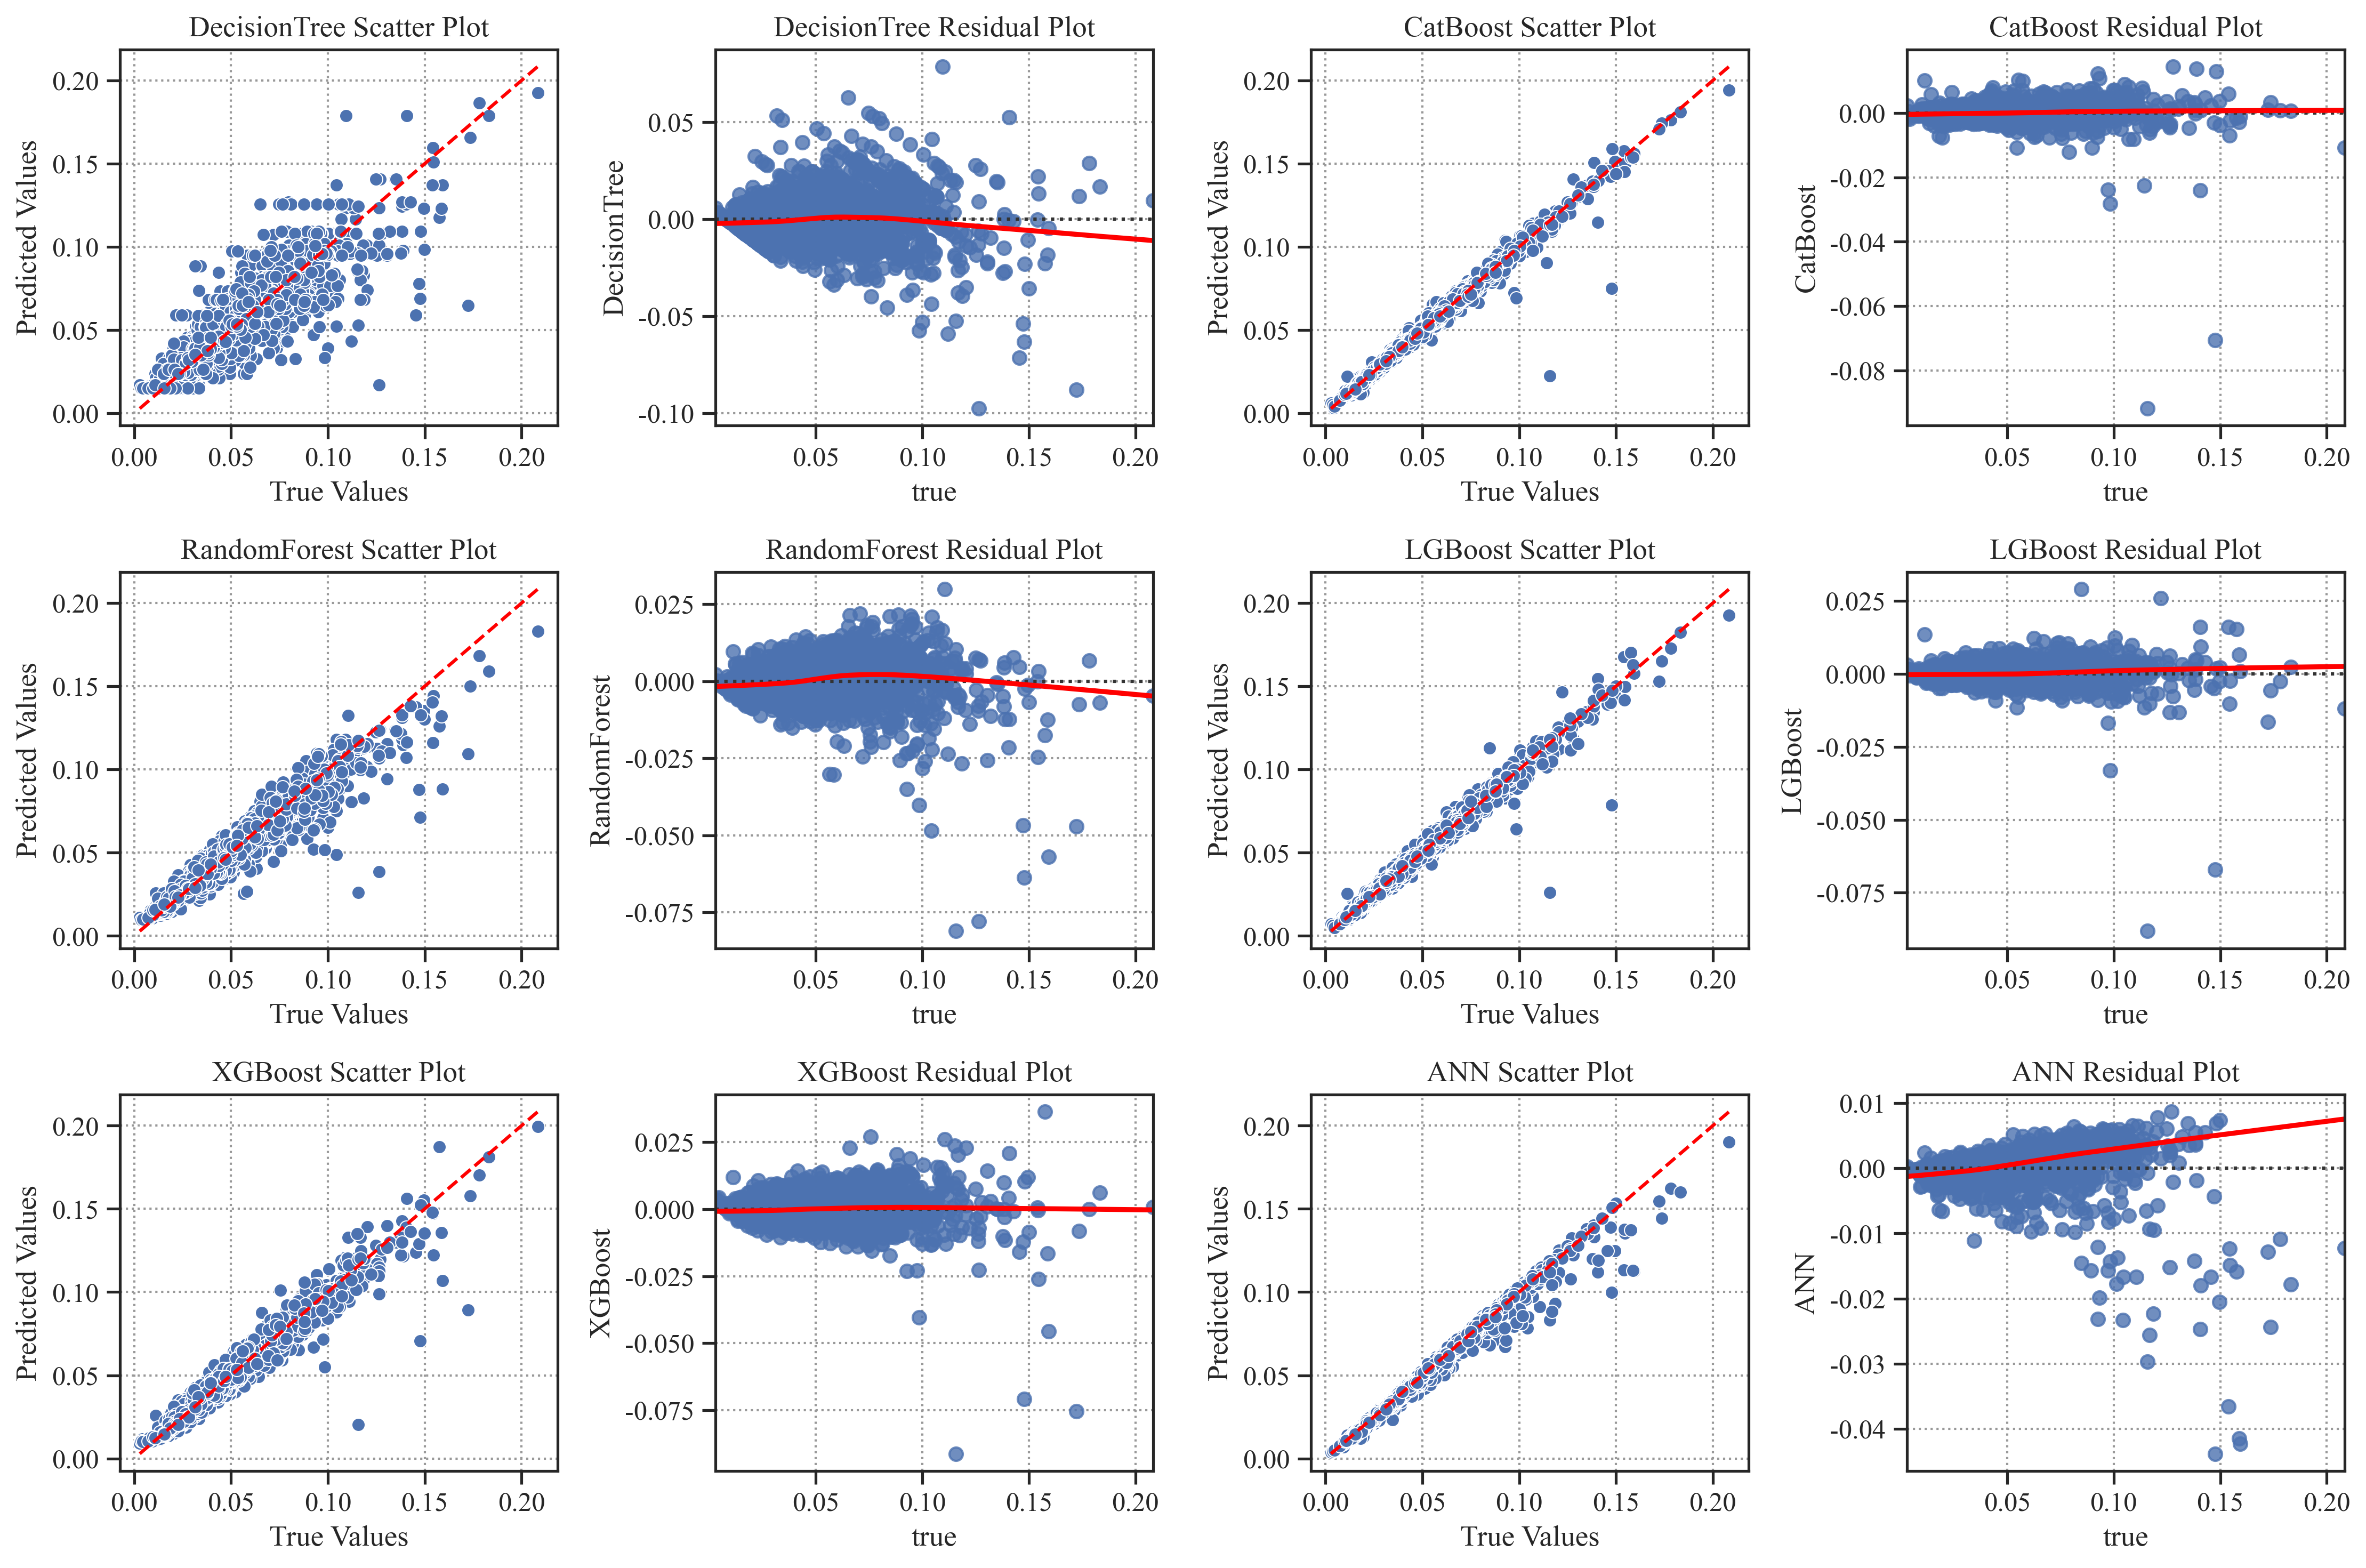

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='ticks', font_scale=1.1)
sns.set_style("ticks", {'axes.grid':True, "grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams['font.family'] = ['Times New Roman','Heiti TC', 'Heiti TC',] 
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
"""模型性能评估"""


fig, axes = plt.subplots(3, 4, figsize=(15, 10), dpi=300)
models = ['DecisionTree', 'RandomForest', 'XGBoost', 'CatBoost', 'LGBoost', 'ANN']
data = Pred.reset_index()
for idx, model in enumerate(models):
    
    axp1 = idx if idx<3 else idx-3, 0 if idx <3 else 2
    axp2 = idx if idx<3 else idx-3, 1 if idx <3 else 3
    # 散点图
    sns.scatterplot(x="true", y=model,data=data, ax=axes[axp1])
    axes[axp1].plot([min(data['true']), max(data['true'])],[min(data['true']), max(data['true'])], color='red',linestyle='--')
    axes[axp1].set_xlabel('True Values')
    axes[axp1].set_ylabel('Predicted Values')
    axes[axp1].set_title(f'{model} Scatter Plot')
    
    sns.residplot(
        x='true', 
        y=model, 
        data=data, 
        ax=axes[axp2],
        lowess=True,  # 平滑曲线
        line_kws={'color': 'red'}
    )
    axes[axp2].set_title(f'{model} Residual Plot')

plt.tight_layout()
plt.savefig('./assert/imgs/模型性能评估.svg', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.savefig('./assert/imgs/模型性能评估.png', dpi=300, bbox_inches='tight', pad_inches=0.0,transparent=True)
plt.show()

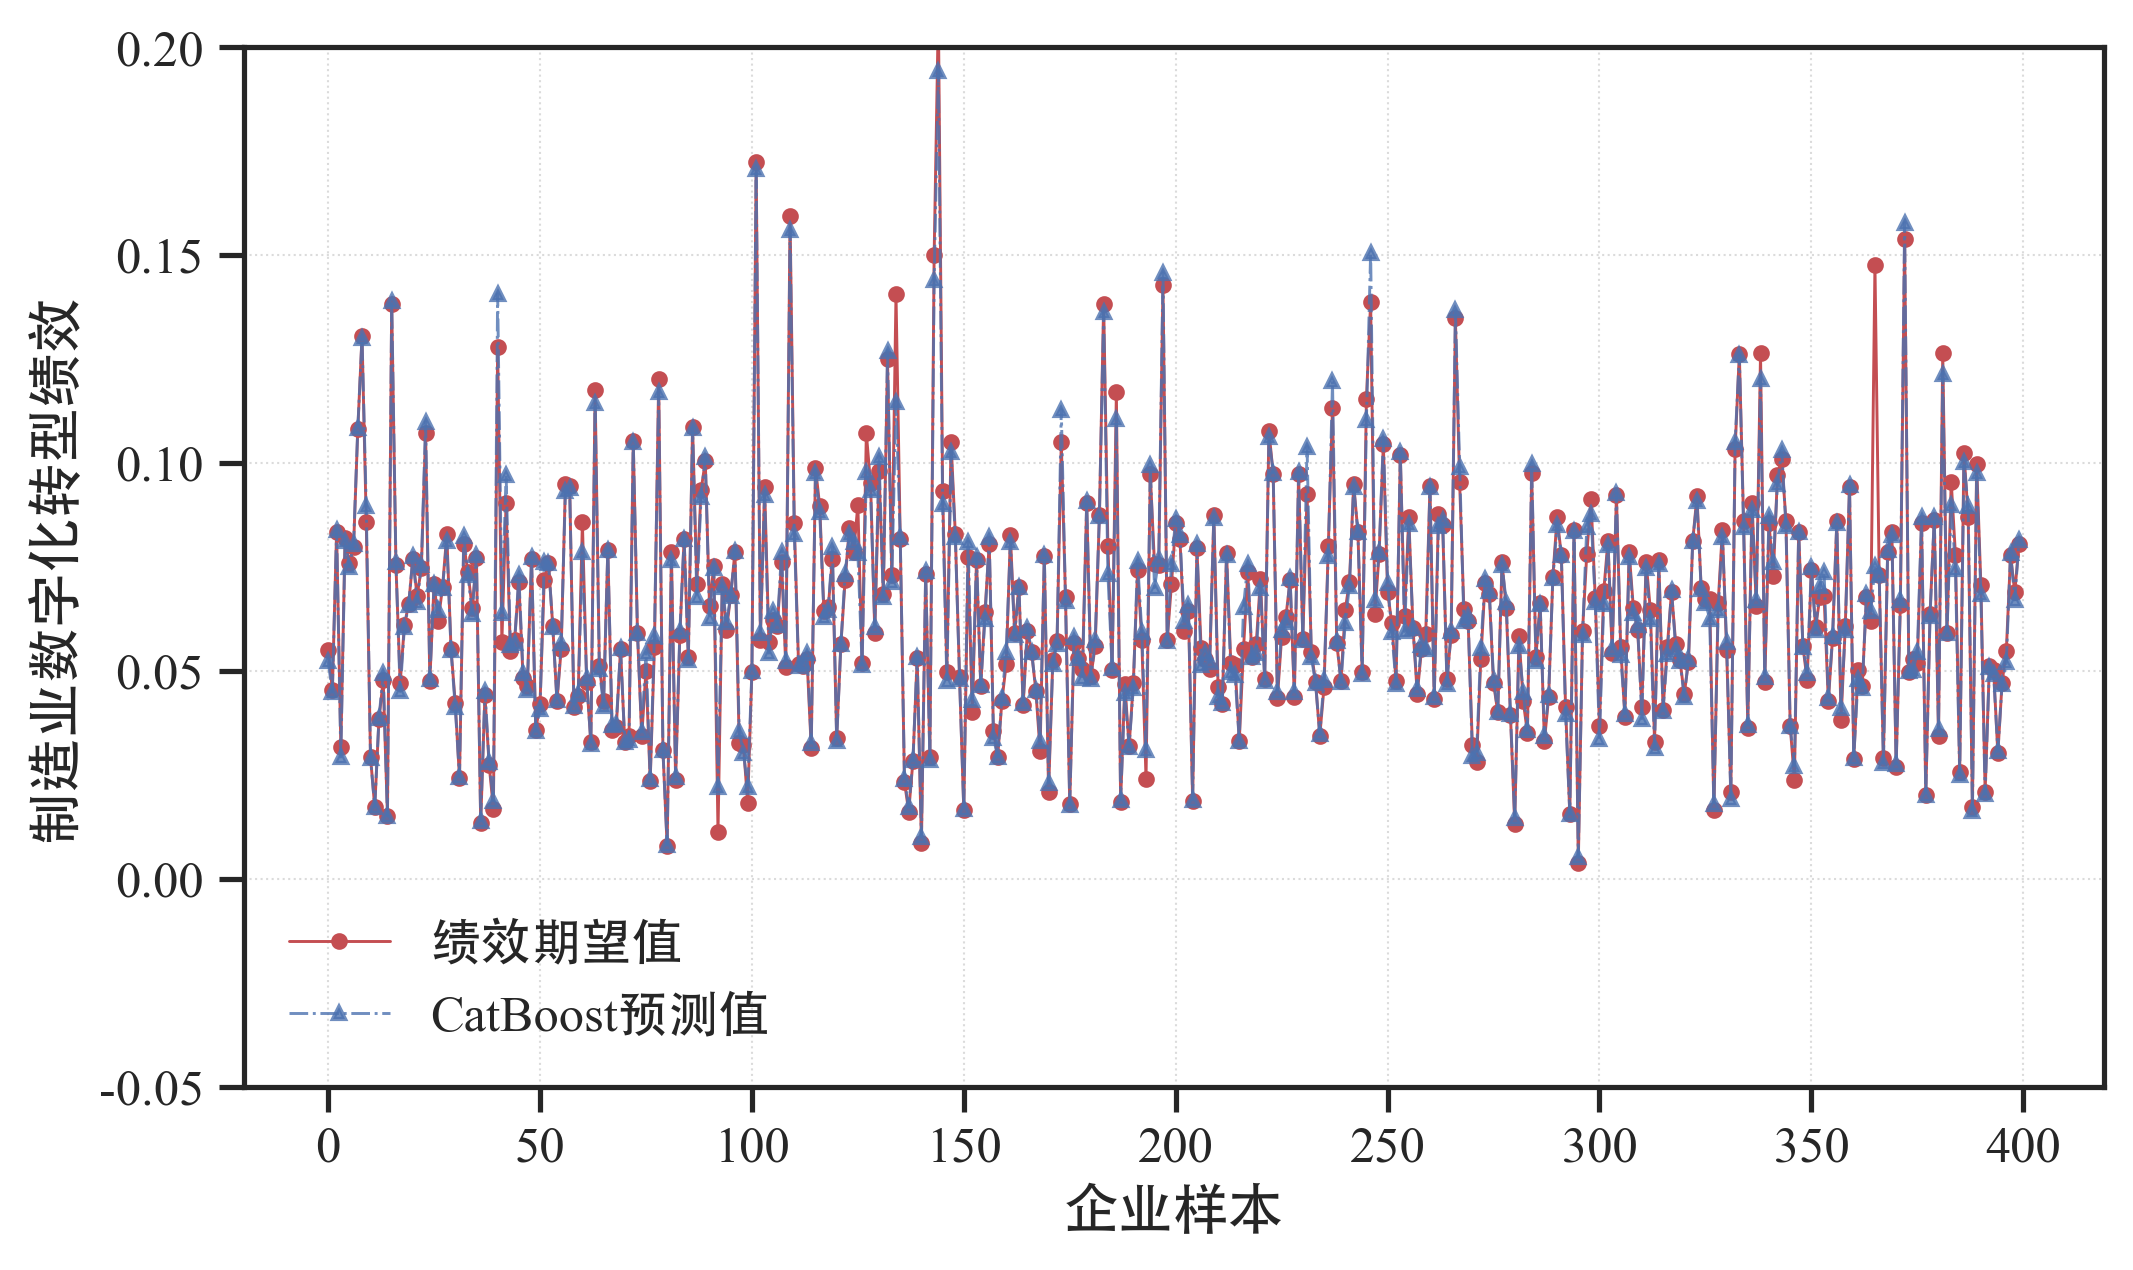

In [4]:
# ANN\CatBoost\true
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), dpi=300)

# print(data[].shape[0])
temp = data[data["截止日期"]==2023].sample(400).copy(deep=True)
temp.reset_index(drop=True, inplace=True)
#  markeredgecolor = 'r',markerfacecolor='y',
ax.plot(temp.index, temp["true"],  color='r',marker='o', linewidth = 0.7, markersize=3, label='绩效期望值')
ax.plot(temp.index, temp["CatBoost"],color='b', marker='^', linestyle='-.', linewidth = 0.7, markersize=3, label='CatBoost预测值', alpha=0.8)

ax.set_ylim((-0.05, 0.2))
ax.set_yticks([-0.05, 0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel("企业样本")
ax.set_ylabel("制造业数字化转型绩效")
# plt.xticks(x[::2],_x_ticks[::2],fontproperties = my_font)
# plt.title("Comparison of True performance and CatBoost performance")
# ax.spines['right'].set_visible(False)

#绘制网格
plt.grid(color='lightgray',linewidth=0.5,alpha=0.8)
plt.legend(ncols=1, frameon=False)
plt.savefig("./assert/imgs/真实值和CatBoost 预测值的变化情况.svg", transparent=True, dpi=300)
plt.show()